# <center> Python分析高潜用户购买画像

# 一、课题背景

- 以京东商城真实的用户、商品和行为数据（脱敏）为基础，通过数据分析的技术和行业知识，构建用户购买商品的分析模型，输出高潜用户和目标商品的匹配结果，为精准营销提供高质量的目标群体。
- 目标：使用电商多个品类下商品的历史销售数据，对某个品类下商品的购买意向

- 数据集：
- 这里涉及到的数据集是最新的数据集：
- Data_User.csv  用户数据集 105,321个用户
- Data_Comment.csv  商品评论 558,552条记录
- Data_Product.csv  预测商品集合 24,187条记录
- Data_Action_201602.csv  2月份行为交互记录 11,485,424条记录
- Data_Action_201603.csv  3月份行为交互记录 25,916,378条记录
- Data_Action_201604.csv  4月份行为交互记录 13,199,934条记录

<img src='img/1.png' alt='alt="FAO"' wid=390>
年龄字段：-1代表未知，1代表15岁以下，2代表16岁~25岁，3代表26-35岁，4代表36-45岁，5代表46-55岁，6代表56岁以上

用户等级：1代表注册会员，2代表铜牌会员，3代表银牌会员，4代表金牌会员，5代表钻石会员
<img src='img/2.png' alt='alt="FAO"' wid=390>
<img src='img/3.png' alt='alt="FAO"' wid=390>
<img src='img/5.png' alt='alt="FAO"' wid=390>

# 二、操作步骤：
（一）数据清洗与格式转化
1. 数据集完整性验证
2. 数据集中是否存在缺失值
3. 数据集中个特征数值应该如何处理
4. 哪些数据是我们想要的，哪些是可以过滤掉的
5. 将有价值数据信息做成新的数据源
6. 去除无腥味交互的商品和用户
7. 去掉浏览量很大而购买很少的用户（惰性/爬虫用户）

（二）EDA/探索性数据分析

# 三、实操

## 3.1 数据集完整性验证

### 3.1.1 检查Data_User中的用户和Data_Action中的用户是否一致

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # 忽视

In [2]:
# 数据量过大，按块处理
def get_big_data(fname, chunk_size=5000):
    data = pd.read_csv(fname, header=0, iterator=True, encoding='gbk')
    chunks = []
    loop = True
    while loop:
        try:
            chunk = data.get_chunk(chunk_size)
            chunks.append(chunk)
        except StopIteration: # 读完了就停止
            loop = False
            print("Iteration is stopped")
    # 拼接数据块
    df = pd.concat(chunks, ignore_index=True)
    return df

In [3]:
Data_User = pd.read_csv('data/Data_User.csv', encoding='gbk')
df_user = Data_User.loc[:, 'user_id'].to_frame()

def user_action_check(df):
    flag = len(df) == len(df_user.merge(df, how='inner'))
#     flag = len(df) == len(pd.merge(df_user,df))
    print("Is action of file from User file?", flag)

for i in range(2, 5):
    filename = 'data/Data_Action_20160'+ str(i) + '.csv'
    df = get_big_data(filename)
    user_action_check(df)
    

Iteration is stopped
Is action of file from User file? True
Iteration is stopped
Is action of file from User file? True
Iteration is stopped
Is action of file from User file? True


### 3.1.2 检查是否有重复记录
- 查看各个数据文件中完全重复的记录，可能解释是重复数据是有意义的，比如用户购买多件商品，同事添加多个数量的商品到购物车等

In [4]:
def deduplicates(filepath, filename, newpath):
    dframe = get_big_data(filepath)
    before = dframe.shape[0]
    dframe.drop_duplicates(inplace=True)
    after = dframe.shape[0]
    delta_dup = before - after    # 前后样本数的差值
    print('No. of duplicate records for ' + filename + ' is: ' + str(delta_dup))
    if delta_dup != 0:
        df.to_csv(newpath, index=None)
    else:
        print ('no duplicate records in ' + filename)

deduplicates('Data/Data_Action_201602.csv', 'Feb.action', 'Data/Data_Action_201602_dedup.csv')
deduplicates('Data/Data_Action_201603.csv', 'Mar.action', 'Data/Data_Action_201603_dedup.csv')
deduplicates('Data/Data_Action_201604.csv', 'Apr.action', 'Data/Data_Action_201604_dedup.csv')
deduplicates('Data/Data_Comment.csv', 'Comment', 'Data_Comment_dedup.csv')
deduplicates('Data/Data_Product.csv', 'Product', 'Data_Product_dedup.csv')
deduplicates('Data/Data_User.csv', 'User', 'Data_User.csv')

Iteration is stopped
No. of duplicate records for Feb.action is: 326334
Iteration is stopped
No. of duplicate records for Mar.action is: 7085038
Iteration is stopped
No. of duplicate records for Apr.action is: 3672710
Iteration is stopped
No. of duplicate records for Comment is: 0
no duplicate records in Comment
Iteration is stopped
No. of duplicate records for Product is: 0
no duplicate records in Product
Iteration is stopped
No. of duplicate records for User is: 0
no duplicate records in User


In [5]:
# 检查重复值
dframe = get_big_data('Data/Data_Action_201602.csv')
isDuplicated = dframe.duplicated()
df_dup = dframe[isDuplicated]
df_dup.groupby(['type']).count()
"""
 结论1. 大量重复是由于 type=1 浏览和 type=6 点击导致
"""

Iteration is stopped


'\n 结论1. 大量重复是由于 type=1 浏览和 type=6 点击导致\n'

### 3.1.3 检查是否存在注册时间在2016-4-15之后的客户

In [6]:
dframe = get_big_data('Data/Data_User.csv')
dframe['user_reg_tm'] = pd.to_datetime(dframe['user_reg_tm'])
dframe.loc[dframe.user_reg_tm>='2016-4-16']

for i in range(2, 5):
    filename = 'Data/Data_Action_20160' + str(i) + '.csv'
    dframe = get_big_data(filename)
    dframe['time'] = pd.to_datetime(dframe['time'])
    temp = dframe.loc[dframe.time>='2016-4-16']
    print(str(i)+"月：\n", temp)

"""
结论2. 没有异常操作（4月15号之后注册）数据，所以这一批用户不删除
"""

Iteration is stopped
Iteration is stopped
2月：
 Empty DataFrame
Columns: [user_id, sku_id, time, model_id, type, cate, brand, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10]
Index: []
Iteration is stopped
3月：
 Empty DataFrame
Columns: [user_id, sku_id, time, model_id, type, cate, brand]
Index: []
Iteration is stopped
4月：
 Empty DataFrame
Columns: [user_id, sku_id, time, model_id, type, cate, brand]
Index: []


'\n结论2. 没有异常操作（4月15号之后注册）数据，所以这一批用户不删除\n'

### 3.1.4 年龄区间处理

In [7]:
# dframe = get_big_data('Data/Data_User.csv')
# for item in range(len(dframe.index)):
#     if dframe['age']
#     dframe['age_range'] = dframe['age']
    
# df_user = pd.read_csv('data/Data_User.csv',encoding='gbk')

# def tranAge(x):
#     if x <= 15:
#         x = '1'
#     elif x >= 16 and x <= 25:
#         x = '2'
#     elif x >= 26 and x <= 35:
#         x = '3'
#     elif x >= 36 and x <= 45:
#         x = '4'
#     elif x >= 46 and x <= 55:
#         x = '5'
#     elif x >= 56:
#         x = '6'
#     return x
# df_user['age']= df_user['age'].apply(tranAge)
# print(df_user.head(1000))
# print (df_user.groupby(df_user['age']).count())    # 有14412个没有透露性别，在年龄值为3时候最多，属于”26—35岁“
# # df_user.to_csv('data/Data_User.csv',index=None)

### user_table特征包括：
- user_id(用户id), age(年龄), sex(性别), user_lv_cd(用户级别),
- browse_num(浏览数)
- addcart_num(加购数), delcart_num(删购数)
- buy_num(购买数), favor_num(收藏数)
- click_num(点击数)
- buy_addcart_ratio(购买转化率)
- buy_browse_ratio(购买浏览转化率)
- buy_click_ratio(购买点击转化率)
- buy_favor_ratio(购买收藏转化率)

### item_table特征包括：
- sku_id, cate, brand, 
- attr1, attr2, attr3,
- browse_num, addcart_num, delcart_num
- buy_num, favor_num, click_num
- buy_browse_ratio, buy_addcart_ratio, buy_click_ratio, buy_favor_ratio
- comment_num, has_bad_comment, bad_comments_ratio

### 3.1.5 构建User_table

In [8]:
# 为使用方便，重新定义文件名
ACTION_201602_FILE = "data/Data_Action_201602.csv"
ACTION_201603_FILE = "data/Data_Action_201603.csv"
ACTION_201604_FILE = "data/Data_Action_201604.csv"
COMMENT_FILE = "data/Data_Comment.csv"
PRODUCT_FILE = "data/Data_Product.csv"
USER_FILE = "data/Data_User.csv"
USER_TABLE_FILE = "data/User_table.csv"
ITEM_TABLE_FILE = "data/Item_table.csv"

In [9]:
from collections import Counter

# 功能函数：对每一个user分组的数据进行统计
def add_type_count(group):
    behavior_type = group.type.astype(int)
    # 统计用户行为类别
    type_count = Counter(behavior_type)
    
    group['browse_num'] = type_count[1]
    group['addcart_num'] = type_count[2]
    group['delcart_num'] = type_count[3]
    group['buy_num'] = type_count[4]
    group['favor_num'] = type_count[5]
    group['click_num'] = type_count[6]
    
    return group[['user_id', 'browse_num', 'addcart_num',
                 'delcart_num', 'buy_num', 'favor_num',
                 'click_num']]

In [10]:
# 对 action 进行数据统计
# 只需要 user_id 和 type 两列数据

def getInfo_from_actionData(fname, chunk_size=50000):
    file = pd.read_csv(fname, header=0, iterator=True, encoding='gbk')
    chunks = []
    flag = True
    while flag:
        try:
            chunk = file.get_chunk(chunk_size)[['user_id', 'type']]
            chunks.append(chunk)
        except StopIteration:
            flag = False
            print("Iteration is stopped")
    # 拼接为dataframe
    df_ac = pd.concat(chunks, ignore_index=True)
    # 按 user_id 分组，对每一组进行统计，as_index表示无索引形式返回数据
    df_ac = df_ac.groupby(['user_id'], as_index=False).apply(add_type_count)
    df_ac = df_ac.drop_duplicates('user_id')
    return df_ac

In [11]:
# 将各个 action 数据的统计量进行聚合
def merge_action_data():
    df_ac = []
    df_ac.append(getInfo_from_actionData(ACTION_201602_FILE))
    df_ac.append(getInfo_from_actionData(ACTION_201603_FILE))
    df_ac.append(getInfo_from_actionData(ACTION_201604_FILE))
    
    df_ac = pd.concat(df_ac, ignore_index=True)
    # 用户在不同 action 表中统计量求和
    df_ac = df_ac.groupby(['user_id'], as_index=False).sum()
    # 构造转化率字段
    df_ac['buy_addcart_ratio'] = df_ac['buy_num']/df_ac['addcart_num'] # 加了多少次购物车才买
    df_ac['buy_browse_ratio'] = df_ac['buy_num']/df_ac['browse_num'] # 浏览了多少次才买
    df_ac['buy_click_ratio'] = df_ac['buy_num']/df_ac['click_num'] # 点击了多少次才买
    df_ac['buy_favor_ratio'] = df_ac['buy_num']/df_ac['favor_num'] # 收藏了多少个才买
    
    # 将大于1的妆化率字段值设置为1，确保数据没有问题
    df_ac.loc[df_ac['buy_addcart_ratio']>1., 'buy_addcart_ratio'] = 1
    df_ac.loc[df_ac['buy_browse_ratio']>1., 'buy_browse_ratio'] = 1
    df_ac.loc[df_ac['buy_click_ratio']>1., 'buy_click_ratio'] = 1
    df_ac.loc[df_ac['buy_favor_ratio']>1., 'buy_favor_ratio'] = 1
    df_ac = df_ac.replace([-np.inf, np.inf], np.nan)
    
    return df_ac

In [12]:
def getInfo_from_UserDate():
    df_user = pd.read_csv(USER_FILE, header=0)
    df_user = df_user.iloc[:, :4]
    return df_user

In [13]:
# 执行目的是得到大表
user_base = getInfo_from_UserDate()
user_bavior = merge_action_data()

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [14]:
user_table = pd.merge(user_base, user_bavior, on='user_id', how='left')
# 保存中间结果为 user_table.csv
user_table.to_csv(USER_TABLE_FILE, index=False)

In [15]:
user_table = pd.read_csv(USER_TABLE_FILE, encoding='gbk')
user_table.head(10)

,user_id,age,sex,user_lv_cd,browse_num,addcart_num,delcart_num,buy_num,favor_num,click_num,buy_addcart_ratio,buy_browse_ratio,buy_click_ratio,buy_favor_ratio
0,200001,6.0,2.0,5,212.0,22.0,13.0,1.0,0.0,414.0,0.045455,0.004717,0.002415,1.0
1,200002,-1.0,0.0,1,127.0,0.0,0.0,0.0,0.0,297.0,NaN,0.000000,0.000000,NaN
2,200003,4.0,1.0,4,221.0,4.0,1.0,0.0,1.0,420.0,0.000000,0.000000,0.000000,0.0
3,200004,-1.0,2.0,1,52.0,0.0,0.0,0.0,0.0,61.0,NaN,0.000000,0.000000,NaN
4,200005,2.0,0.0,4,36.0,0.0,0.0,0.0,0.0,56.0,NaN,0.000000,0.000000,NaN
5,200006,4.0,2.0,2,182.0,0.0,0.0,0.0,4.0,183.0,NaN,0.000000,0.000000,0.0
6,200007,4.0,2.0,3,286.0,4.0,4.0,0.0,0.0,447.0,0.000000,0.000000,0.000000,NaN
7,200008,-1.0,2.0,3,75.0,0.0,0.0,0.0,0.0,160.0,NaN,0.000000,0.000000,NaN
8,200009,4.0,2.0,2,10.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,NaN,NaN
9,200010,4.0,2.0,3,30.0,4.0,1.0,0.0,0.0,47.0,0.000000,0.000000,0.000000,NaN


### 3.1.6 构建Item_table

In [16]:
"""sku_id, cate, brand,
attr1, attr2, attr3,
browse_num, addcart_num, delcart_num
buy_num, favor_num, click_num
buy_browse_ratio, buy_addcart_ratio, buy_click_ratio, buy_favor_ratio
comment_num, has_bad_comment, bad_comments_ratio"""

'sku_id, cate, brand,\nattr1, attr2, attr3,\nbrowse_num, addcart_num, delcart_num\nbuy_num, favor_num, click_num\nbuy_browse_ratio, buy_addcart_ratio, buy_click_ratio, buy_favor_ratio\ncomment_num, has_bad_comment, bad_comments_ratio'

In [17]:
# 读取 product 中的商品信息
def get_product_info():
    df_item = pd.read_csv(PRODUCT_FILE, encoding='gbk')
    return df_item

In [18]:
# Counter方法：将 type 进行键值分组
def add_type_count(group):
    behavior_type = group.type.astype(int)
    type_cnt = Counter(behavior_type)
    
    group['browse_num'] = type_cnt[1]
    group['addcart_num'] = type_cnt[2]
    group['delcart_num'] = type_cnt[3]
    group['buy_num'] = type_cnt[4]
    group['favor_num'] = type_cnt[5]
    group['click_num'] = type_cnt[6]
    
    return group[['sku_id', 'browse_num', 'addcart_num',
                 'delcart_num', 'buy_num', 'favor_num',
                 'click_num']]


In [19]:
# 分组统计sku的行动类型
def getInfo_from_actionDate(fname, chunk_size=50000):
    reader = pd.read_csv(fname, header=0, iterator=True, encoding='gbk')
    chunks = []
    flag = True
    while flag:
        try:
            chunk = reader.get_chunk(chunk_size)[['sku_id', 'type']]
            chunks.append(chunk)
        except StopIteration:
            flag = False
            print("Iteration is stopped")
    df_ac = pd.concat(chunks, ignore_index=True)    
    df_ac = df_ac.groupby(['sku_id'], as_index=False).apply(add_type_count)
    # select unique row
    df_ac.drop_duplicates('sku_id', inplace=True)
    
    return df_ac

In [20]:
# 获取评论中的商品数据,如果存在某一个商品有两个日期的评论，我们取最晚的那一个
def get_from_comment():
    reader = pd.read_csv(COMMENT_FILE, encoding='gbk')
    df_comments = pd.DataFrame(reader)
    df_comments['dt'] = pd.to_datetime(df_comments['dt'])
    # find latest comment index
    idx = df_comments.groupby('sku_id')['dt'].transform(max)== df_comments['dt']
    df_comments = df_comments[idx]
    
    return df_comments[['sku_id', 'comment_num',
                        'has_bad_comment', 'bad_comment_rate']]

In [21]:
# 方法：合并数据

def merge_action_data():
    df_ac = []
    df_ac.append(getInfo_from_actionDate(ACTION_201602_FILE))
    df_ac.append(getInfo_from_actionDate(ACTION_201603_FILE))
    df_ac.append(getInfo_from_actionDate(ACTION_201604_FILE))
    df_ac = pd.concat(df_ac, ignore_index=True)
    
    df_ac = df_ac.groupby(['sku_id'], as_index=False).sum()
    
    df_ac['buy_browse_ratio'] = df_ac['buy_num'] / df_ac['browse_num']
    df_ac['buy_addcart_ratio'] = df_ac['buy_num'] / df_ac['addcart_num']
    df_ac['buy_click_ratio'] = df_ac['buy_num'] / df_ac['click_num']
    df_ac['buy_favor_ratio'] = df_ac['buy_num'] / df_ac['favor_num']
    
    df_ac.loc[df_ac['buy_browse_ratio']>1., 'buy_browse_ratio'] = 1.
    df_ac.loc[df_ac['buy_addcart_ratio']>1., 'buy_addcart_ratio'] = 1.
    df_ac.loc[df_ac['buy_click_ratio']>1., 'buy_click_ratio'] = 1.
    df_ac.loc[df_ac['buy_favor_ratio']>1., 'buy_favor_ratio'] = 1.
    df_ac = df_ac.replace([np.inf, -np.inf], np.nan)
    print(len(df_ac))
    
    return df_ac

In [22]:
item_base = get_product_info()
item_behavior = merge_action_data()
item_comment = get_from_comment()

# SQL：left join
item_behavior = pd.merge(item_base, item_behavior, on='sku_id', how='left')
item_behavior = pd.merge(item_behavior, item_comment, on='sku_id', how='left')

item_behavior.to_csv(ITEM_TABLE_FILE, index=False)

Iteration is stopped
Iteration is stopped
Iteration is stopped
26712


### 3.1.7 用户清洗

In [23]:
fpath_UserTable = 'data/User_table.csv'
user_table = pd.read_csv(fpath_UserTable, header=0)
# 输出格式设置，保留三位小数
pd.options.display.float_format = '{:,.3f}'.format
user_table.describe()


"""
根据count，共105321个id，3个age和sex空值
根据浏览、加购、删购和购买数量只有103339条数据，说明存在用户无任何交互记录，因此可删除上述客户
"""
# 删除age、sex为空，浏览、加购、删购和购买皆为空的记录
df_nage = user_table[user_table['age'].isnull()]
user_table.drop(df_nage.index, axis=0, inplace=True)


df_naction = user_table[
    (user_table['browse_num'].isnull()) & (user_table['addcart_num'].isnull())
    & (user_table['delcart_num'].isnull()) & (user_table['buy_num'].isnull())
    & (user_table['favor_num'].isnull()) & (user_table['click_num'].isnull())
]

user_table.drop(df_naction.index, axis=0, inplace=True)
print(len(user_table))

103336


In [24]:
# 统计无购买记录的用户，并删除
df_bzero = user_table[user_table['buy_num']==0]
user_table.drop(df_bzero.index, inplace=True)
print(len(user_table))

24585


In [25]:
# 浏览购买转化比和点击购买转化比小于0.05%的用户为惰性用户
# 删除爬虫及惰性用户
df_bbr = user_table[user_table['buy_browse_ratio']<0.0005]
user_table.drop(df_bbr.index, inplace=True, axis=0)
df_bcr = user_table[user_table['buy_click_ratio']<0.0005]
user_table.drop(df_bcr.index, inplace=True, axis=0)
len(user_table)

24291

In [26]:
user_table.describe()

,user_id,age,sex,user_lv_cd,browse_num,addcart_num,delcart_num,buy_num,favor_num,click_num,buy_addcart_ratio,buy_browse_ratio,buy_click_ratio,buy_favor_ratio
count,"24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000","24,291.000"
mean,"250,381.269",2.908,1.023,4.282,246.697,8.945,3.984,1.557,1.344,403.595,0.390,0.023,0.034,0.878
std,"29,946.583",1.498,0.959,0.804,294.274,11.781,6.399,1.239,3.716,492.576,0.330,0.056,0.143,0.270
min,"200,001.000",-1.000,0.000,2.000,0.000,0.000,0.000,1.000,0.000,0.000,0.005,0.001,0.001,0.019
25%,"224,744.500",3.000,0.000,4.000,62.000,2.000,0.000,1.000,0.000,96.000,0.125,0.004,0.003,1.000
50%,"248,623.000",3.000,1.000,4.000,150.000,5.000,2.000,1.000,0.000,240.000,0.250,0.009,0.006,1.000
75%,"275,855.000",4.000,2.000,5.000,321.000,11.000,5.000,2.000,1.000,526.000,0.500,0.021,0.014,1.000
max,"305,318.000",6.000,2.000,5.000,"5,256.000",208.000,153.000,37.000,67.000,"7,823.000",1.000,1.000,1.000,1.000


## 3.2 EDA/探索性数据分析

### 3.2.1 周一到周日每天购买情况

In [27]:
"""
ACTION_201602_FILE = "data/Data_Action_201602.csv"
ACTION_201603_FILE = "data/Data_Action_201603.csv"
ACTION_201604_FILE = "data/Data_Action_201604.csv"
COMMENT_FILE = "data/Data_Comment.csv"
PRODUCT_FILE = "data/Data_Product.csv"
USER_FILE = "data/Data_User.csv"
USER_TABLE_FILE = "data/User_table.csv"
ITEM_TABLE_FILE = "data/Item_table.csv"
"""
def get_from_actionData(filename, chunksize=50000):
    reader = pd.read_csv(filename, encoding='gbk', header=0, iterator=True)
    chunks = []
    flag = True
    while flag:
        try:
            chunk = reader.get_chunk(chunksize)[['user_id', 'sku_id', 'time', 'type']]
            chunks.append(chunk)
        except StopIteration:
            flag = False
            print("Iteration is stopped.")
    df_ac = pd.concat(chunks, ignore_index=True)
    # type=4为购买
    df_ac = df_ac[df_ac['type']==4]
    
    return df_ac[['user_id', 'sku_id', 'time']]

In [28]:
df_ac = []
df_ac.append(get_from_actionData(ACTION_201602_FILE))
df_ac.append(get_from_actionData(ACTION_201603_FILE))
df_ac.append(get_from_actionData(ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

df_ac['week'] = pd.to_datetime(df_ac['time']).dt.weekday
# monday 为 0，转换为英文格式
df_ac.loc[df_ac['week']==0, 'week'] = 'Monday'
df_ac.loc[df_ac['week']==1, 'week'] = 'Tuesday'
df_ac.loc[df_ac['week']==2, 'week'] = 'Wednesday'
df_ac.loc[df_ac['week']==3, 'week'] = 'Thursday'
df_ac.loc[df_ac['week']==4, 'week'] = 'Friday'
df_ac.loc[df_ac['week']==5, 'week'] = 'Saturday'
df_ac.loc[df_ac['week']==6, 'week'] = 'Sunday'
df_ac.head()

Iteration is stopped.
Iteration is stopped.
Iteration is stopped.


,user_id,sku_id,time,week
0,269365,166345,2016/2/1 0:01,Monday
1,235443,36692,2016/2/1 0:02,Monday
2,247689,9112,2016/2/1 0:03,Monday
3,273959,102034,2016/2/1 0:05,Monday
4,226791,163550,2016/2/1 0:06,Monday


In [29]:
# 周一到周日每天购买用户个数 - user
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_daily_user = df_ac.groupby('week')['user_id'].nunique().reindex(labels)
group_daily_user = group_daily_user.to_frame().reset_index()
group_daily_user.columns = ['weekday', 'user_num']
print(group_daily_user)

# 周一到周日每天购买商品数 - sku
group_daily_sku = df_ac.groupby('week')['sku_id'].nunique().reindex(labels)
group_daily_sku = group_daily_sku.to_frame().reset_index()
group_daily_sku.columns = ['weekday', 'sku_num']
print(group_daily_sku)

# 周一到周日每天购买记录个数 - purchase
group_daily_purchase = df_ac.groupby('week').size().reindex(labels)
group_daily_purchase = group_daily_purchase.to_frame().reset_index()
group_daily_purchase.columns = ['weekday', 'user_sku_num']
group_daily_purchase

     weekday  user_num
0     Monday      4878
1    Tuesday      6059
2  Wednesday      4015
3   Thursday      5260
4     Friday      4890
5   Saturday      3053
6     Sunday      2607
     weekday  sku_num
0     Monday     1602
1    Tuesday     1819
2  Wednesday     1607
3   Thursday     1596
4     Friday     1618
5   Saturday     1370
6     Sunday     1303


,weekday,user_sku_num
0,Monday,6053
1,Tuesday,7653
2,Wednesday,4982
3,Thursday,6533
4,Friday,5998
5,Saturday,3716
6,Sunday,3214


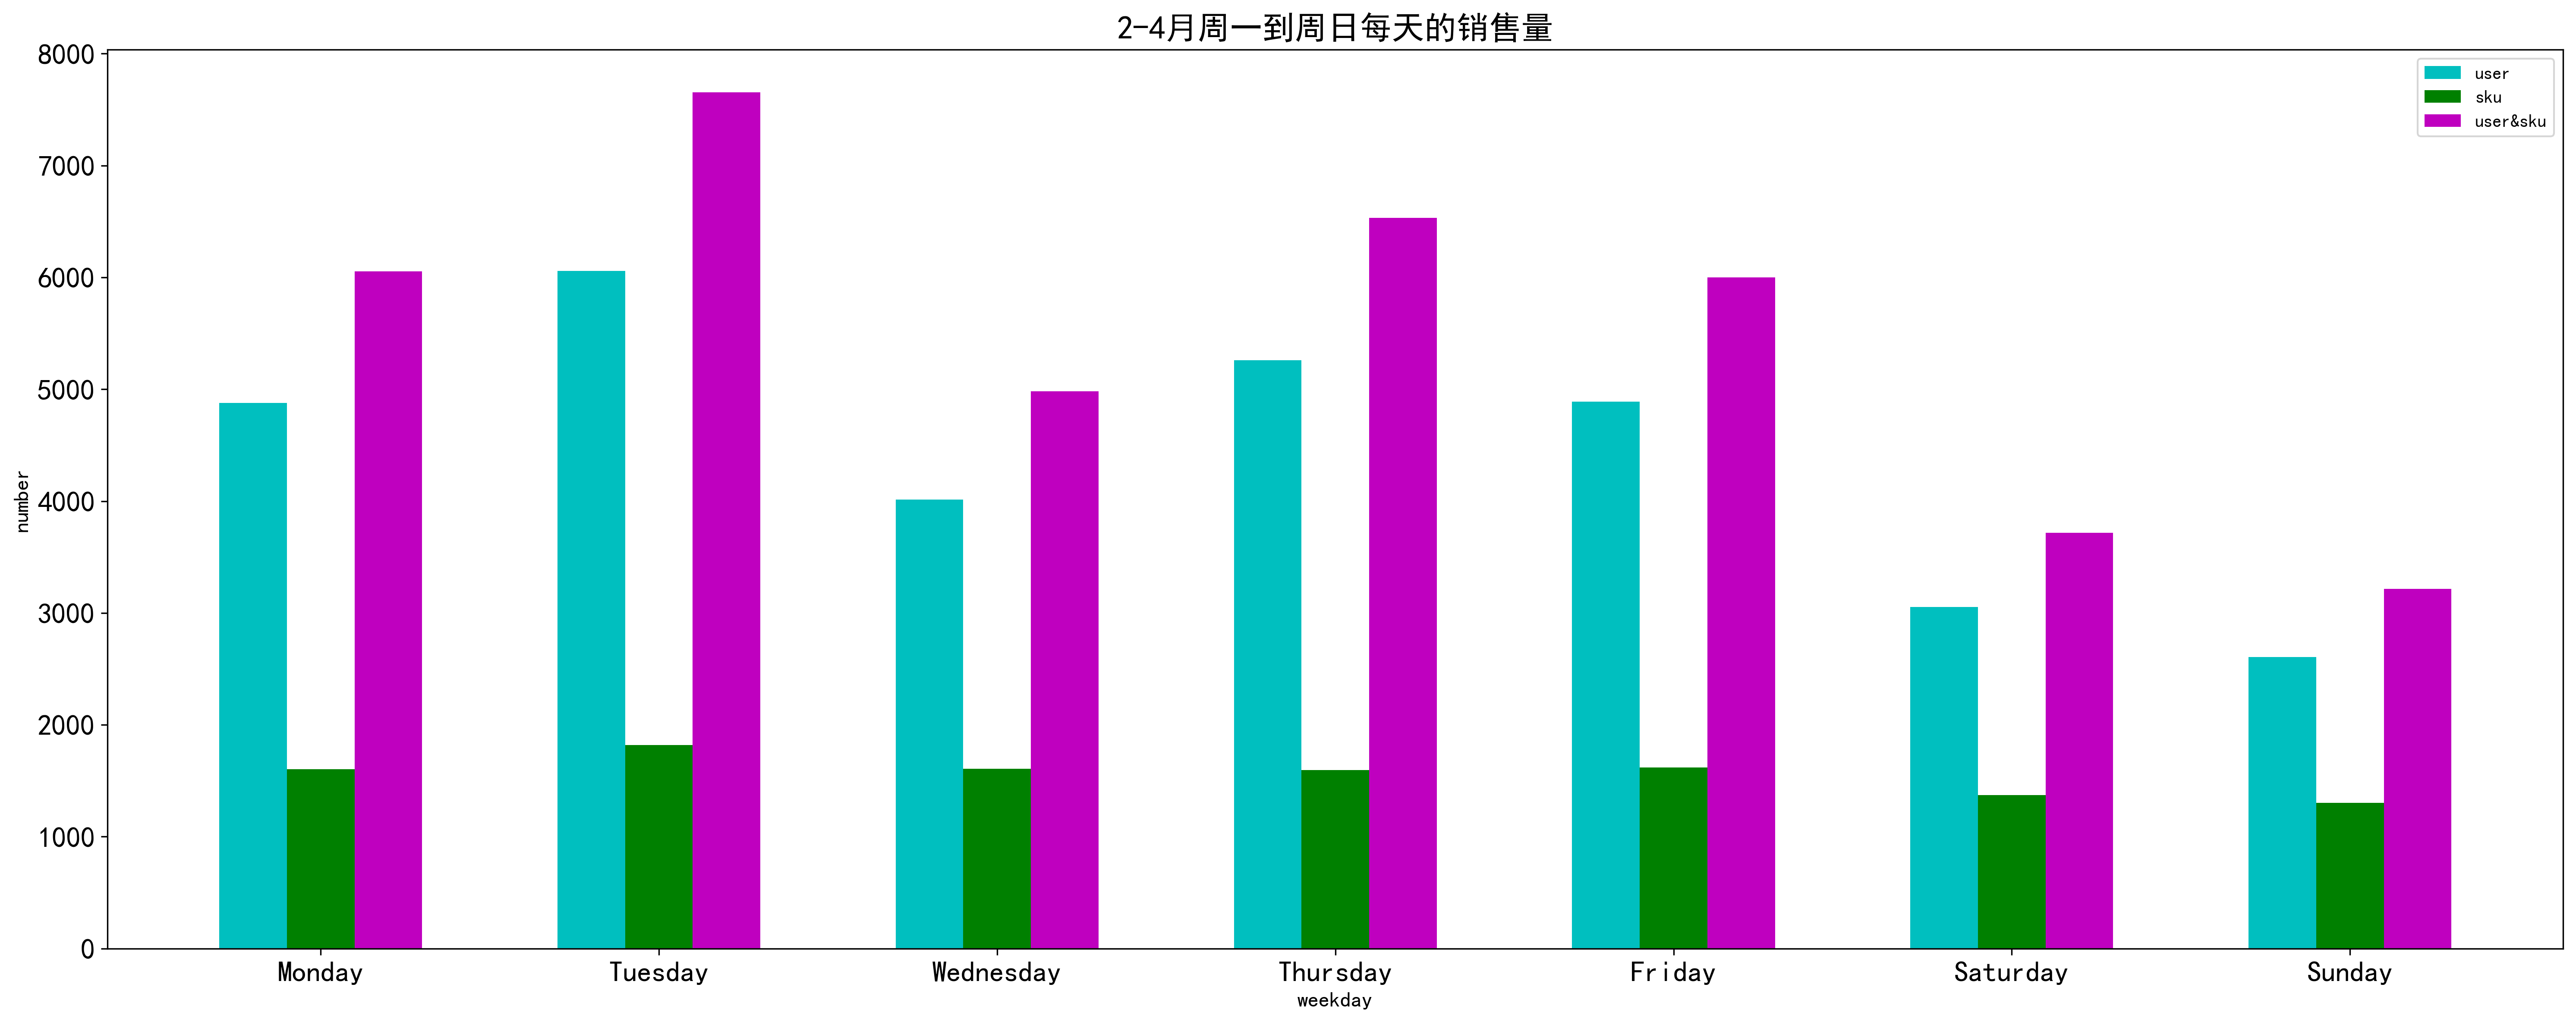

In [30]:
"""构图"""
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(20, 8), dpi=300)
# 图形设置
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
width = 0.2
x = np.arange(len(labels))
# 画图 
rect1 = plt.bar(x-width, group_daily_user['user_num'], width, label='user', color='c')
rect2 = plt.bar(x, group_daily_sku['sku_num'], width, label='sku', color='g')
rect3 = plt.bar(x+width, group_daily_purchase['user_sku_num'], width, label='user&sku', color='m')

plt.xticks(x, labels, size=16)
plt.yticks(size=16)

plt.xlabel('weekday', size=12)
plt.ylabel('number', size=12)
plt.title("2-4月周一到周日每天的销售量", size=18)
plt.legend()
plt.tight_layout()
plt.show()

### 3.2.2 2016年2月中各天购买量

In [31]:
df_ac02 = get_from_actionData(ACTION_201602_FILE)
df_ac02['Day'] = pd.to_datetime(df_ac02['time']).apply(lambda x: x.day)
df_ac02.head()

Iteration is stopped.


,user_id,sku_id,time,Day
351,269365,166345,2016/2/1 0:01,1
649,235443,36692,2016/2/1 0:02,1
980,247689,9112,2016/2/1 0:03,1
1719,273959,102034,2016/2/1 0:05,1
2153,226791,163550,2016/2/1 0:06,1


In [32]:
group_user_02 = df_ac02.groupby('Day')['user_id'].nunique()
group_sku_02 = df_ac02.groupby('Day')['sku_id'].nunique()
group_purchase_02 = df_ac02.groupby('Day').size()
group_purchase_02

Day
1    539
2    462
3    357
4     24
dtype: int64

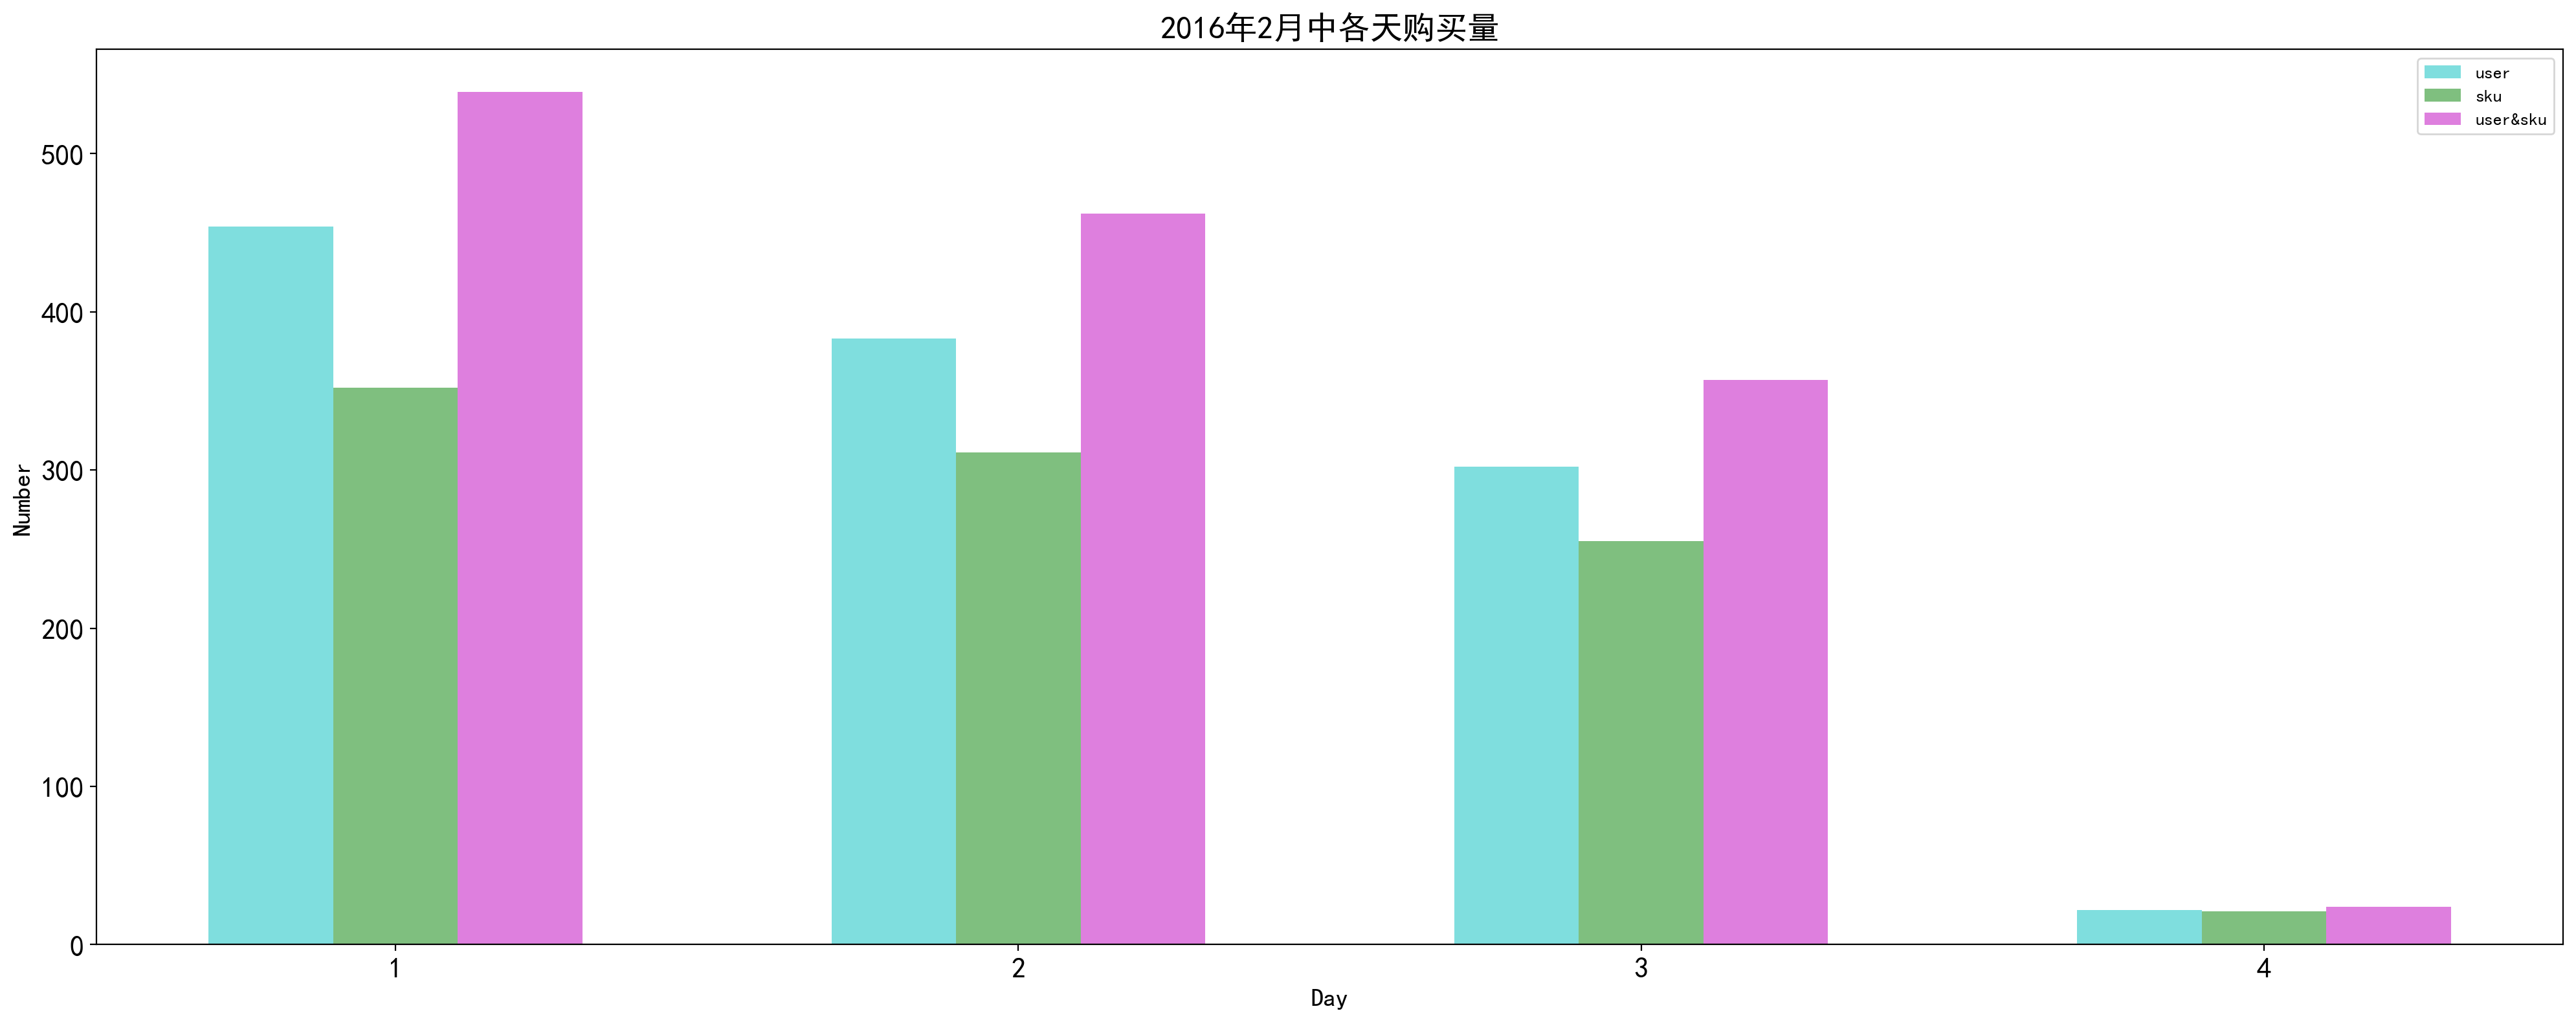

In [33]:
# 构图
fig = plt.figure(figsize=(20, 8), dpi=200)
bar_width = 0.2
x = group_user_02.index
rect1 = plt.bar(x-bar_width, group_user_02.values, bar_width, 
                alpha=0.5, color='c', label='user')
rect2 = plt.bar(x, group_sku_02.values, bar_width, 
                alpha=0.5, color='g', label='sku')
rect3 = plt.bar(x+bar_width, group_purchase_02.values, bar_width, 
                alpha=0.5, color='m', label='user&sku')
plt.xticks(x, size=16)
plt.yticks(size=16)
plt.xlabel('Day', size=14)
plt.ylabel('Number', size=14)
plt.title("2016年3月中各天购买量", size=18)
plt.legend()
plt.tight_layout()
plt.show()

### 3.2.2 2016年3月中各天购买量

In [38]:
df_ac03 = get_from_actionData(ACTION_201603_FILE)
df_ac03['Day'] = pd.to_datetime(df_ac03['time']).apply(lambda x: x.day)
group_user_03 = df_ac03.groupby('Day')['user_id'].nunique()
group_sku_03 = df_ac03.groupby('Day')['sku_id'].nunique()
group_purchase_03 = df_ac03.groupby('Day').size()
group_purchase_03

Iteration is stopped.


Day
1     1140
2      685
3      634
4      700
5      563
6      587
7     1416
8      757
9      601
10     929
11     814
12     703
13     542
14    1548
15    2829
16    1014
17     552
18     640
19     531
20     453
21     655
22     557
23     495
24     609
25     846
26     501
27     507
28     685
29     737
30     584
31     674
dtype: int64

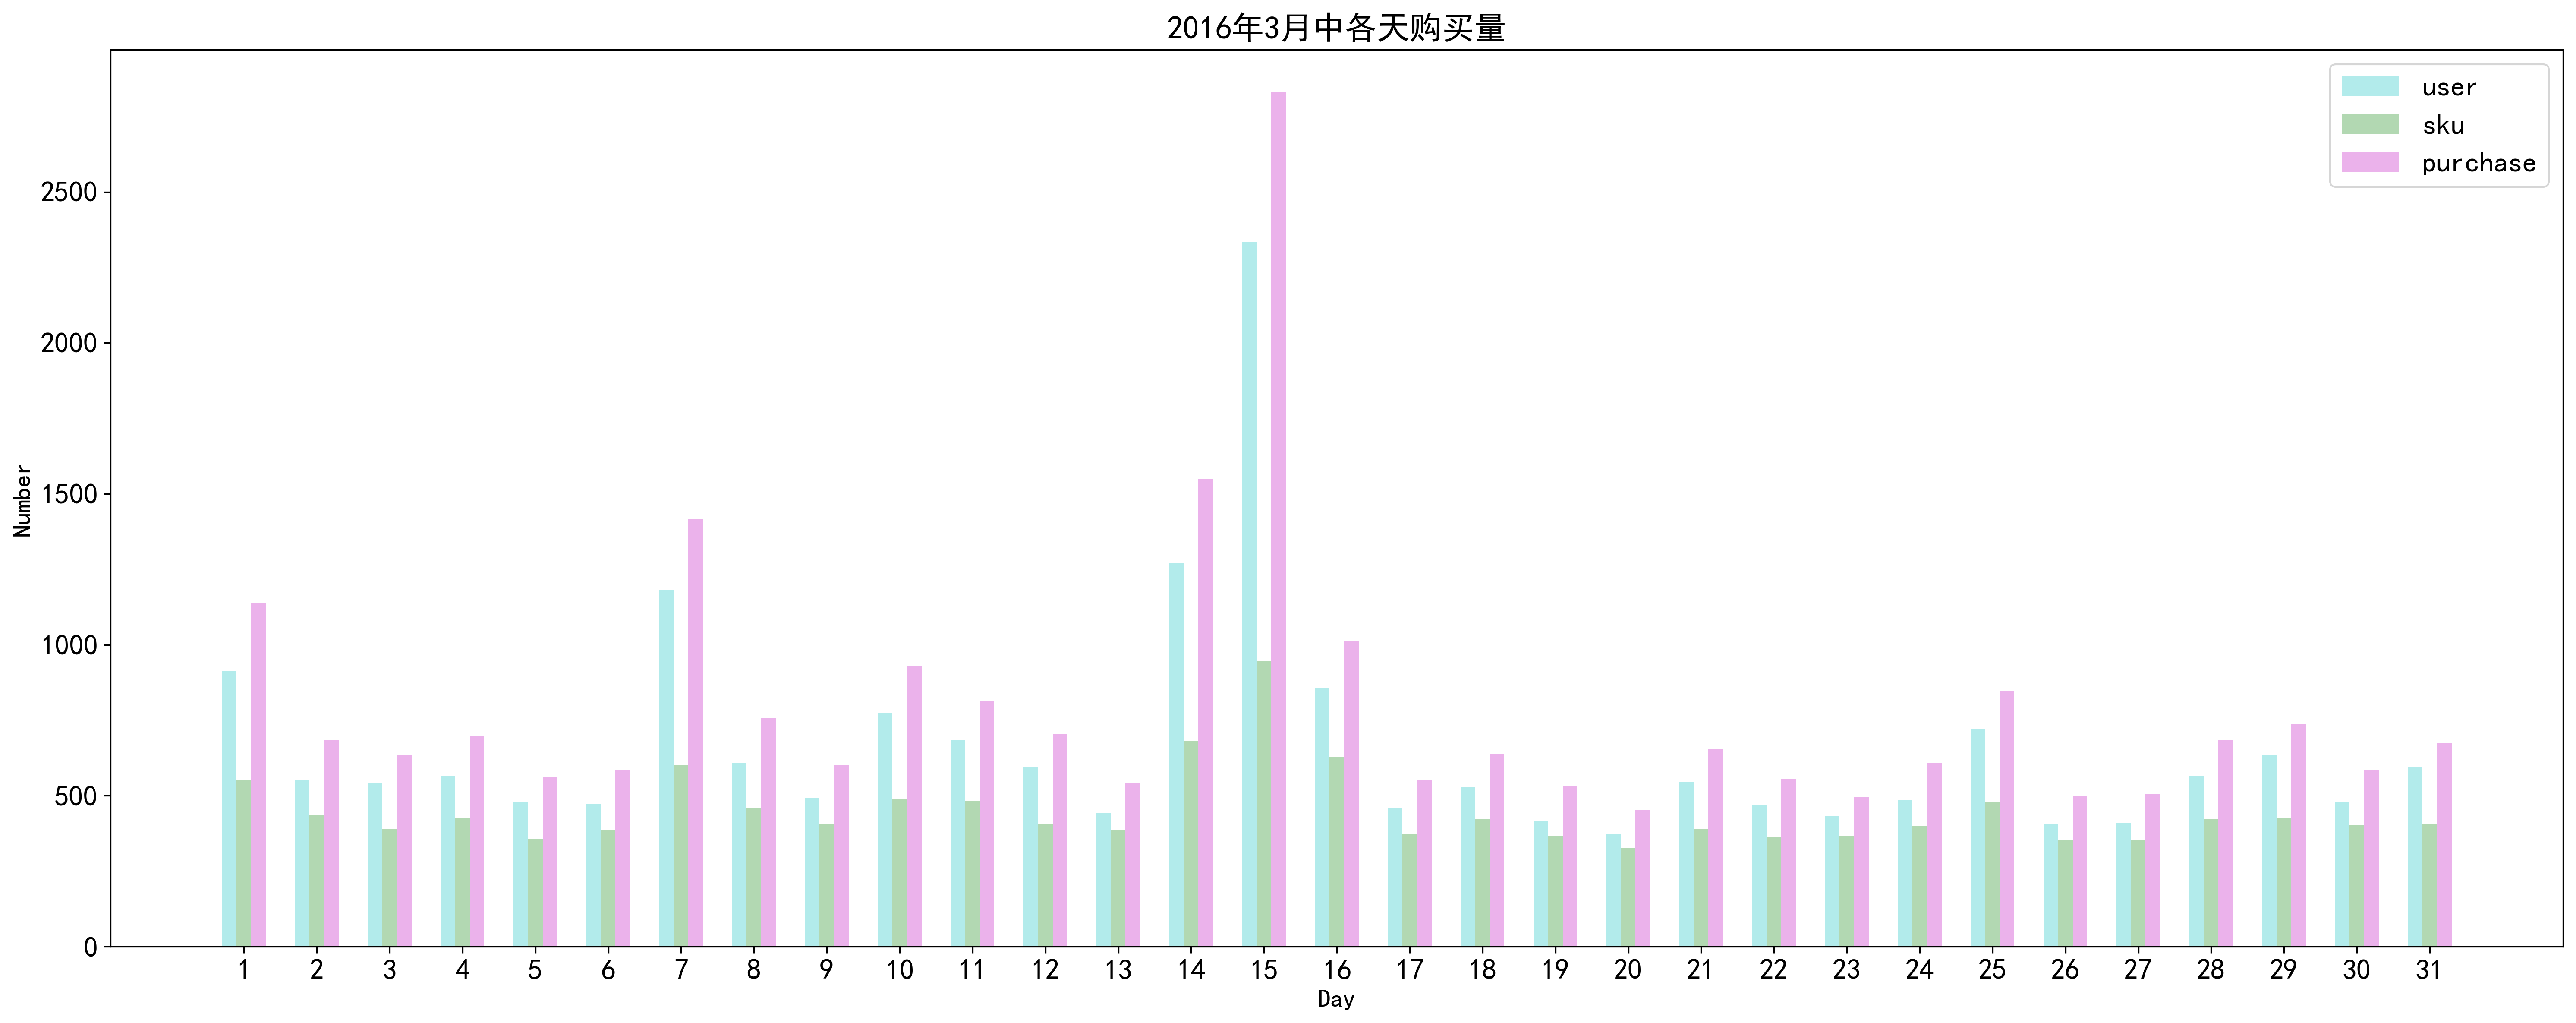

'\n315打假活动，促进交易量\n'

In [49]:
# 构图
fig = plt.figure(figsize=(20, 8), dpi=300)
x = group_user_03.index
width = 0.2
opacity = 0.3
rect1 = plt.bar(x-width, group_user_03.values, width, color='c', alpha=opacity, label='user')
rect2 = plt.bar(x, group_sku_03.values, width, color='g', alpha=opacity, label='sku')
rect3 = plt.bar(x+width, group_purchase_03.values, width, color='m', alpha=opacity, label='purchase')
plt.xlabel('Day', size=14)
plt.xticks(x, size=16)
plt.ylabel('Number', size=14)
plt.yticks(size=16)
plt.title("2016年3月中各天购买量", size=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

"""
315打假活动，促进交易量
"""

Iteration is stopped.


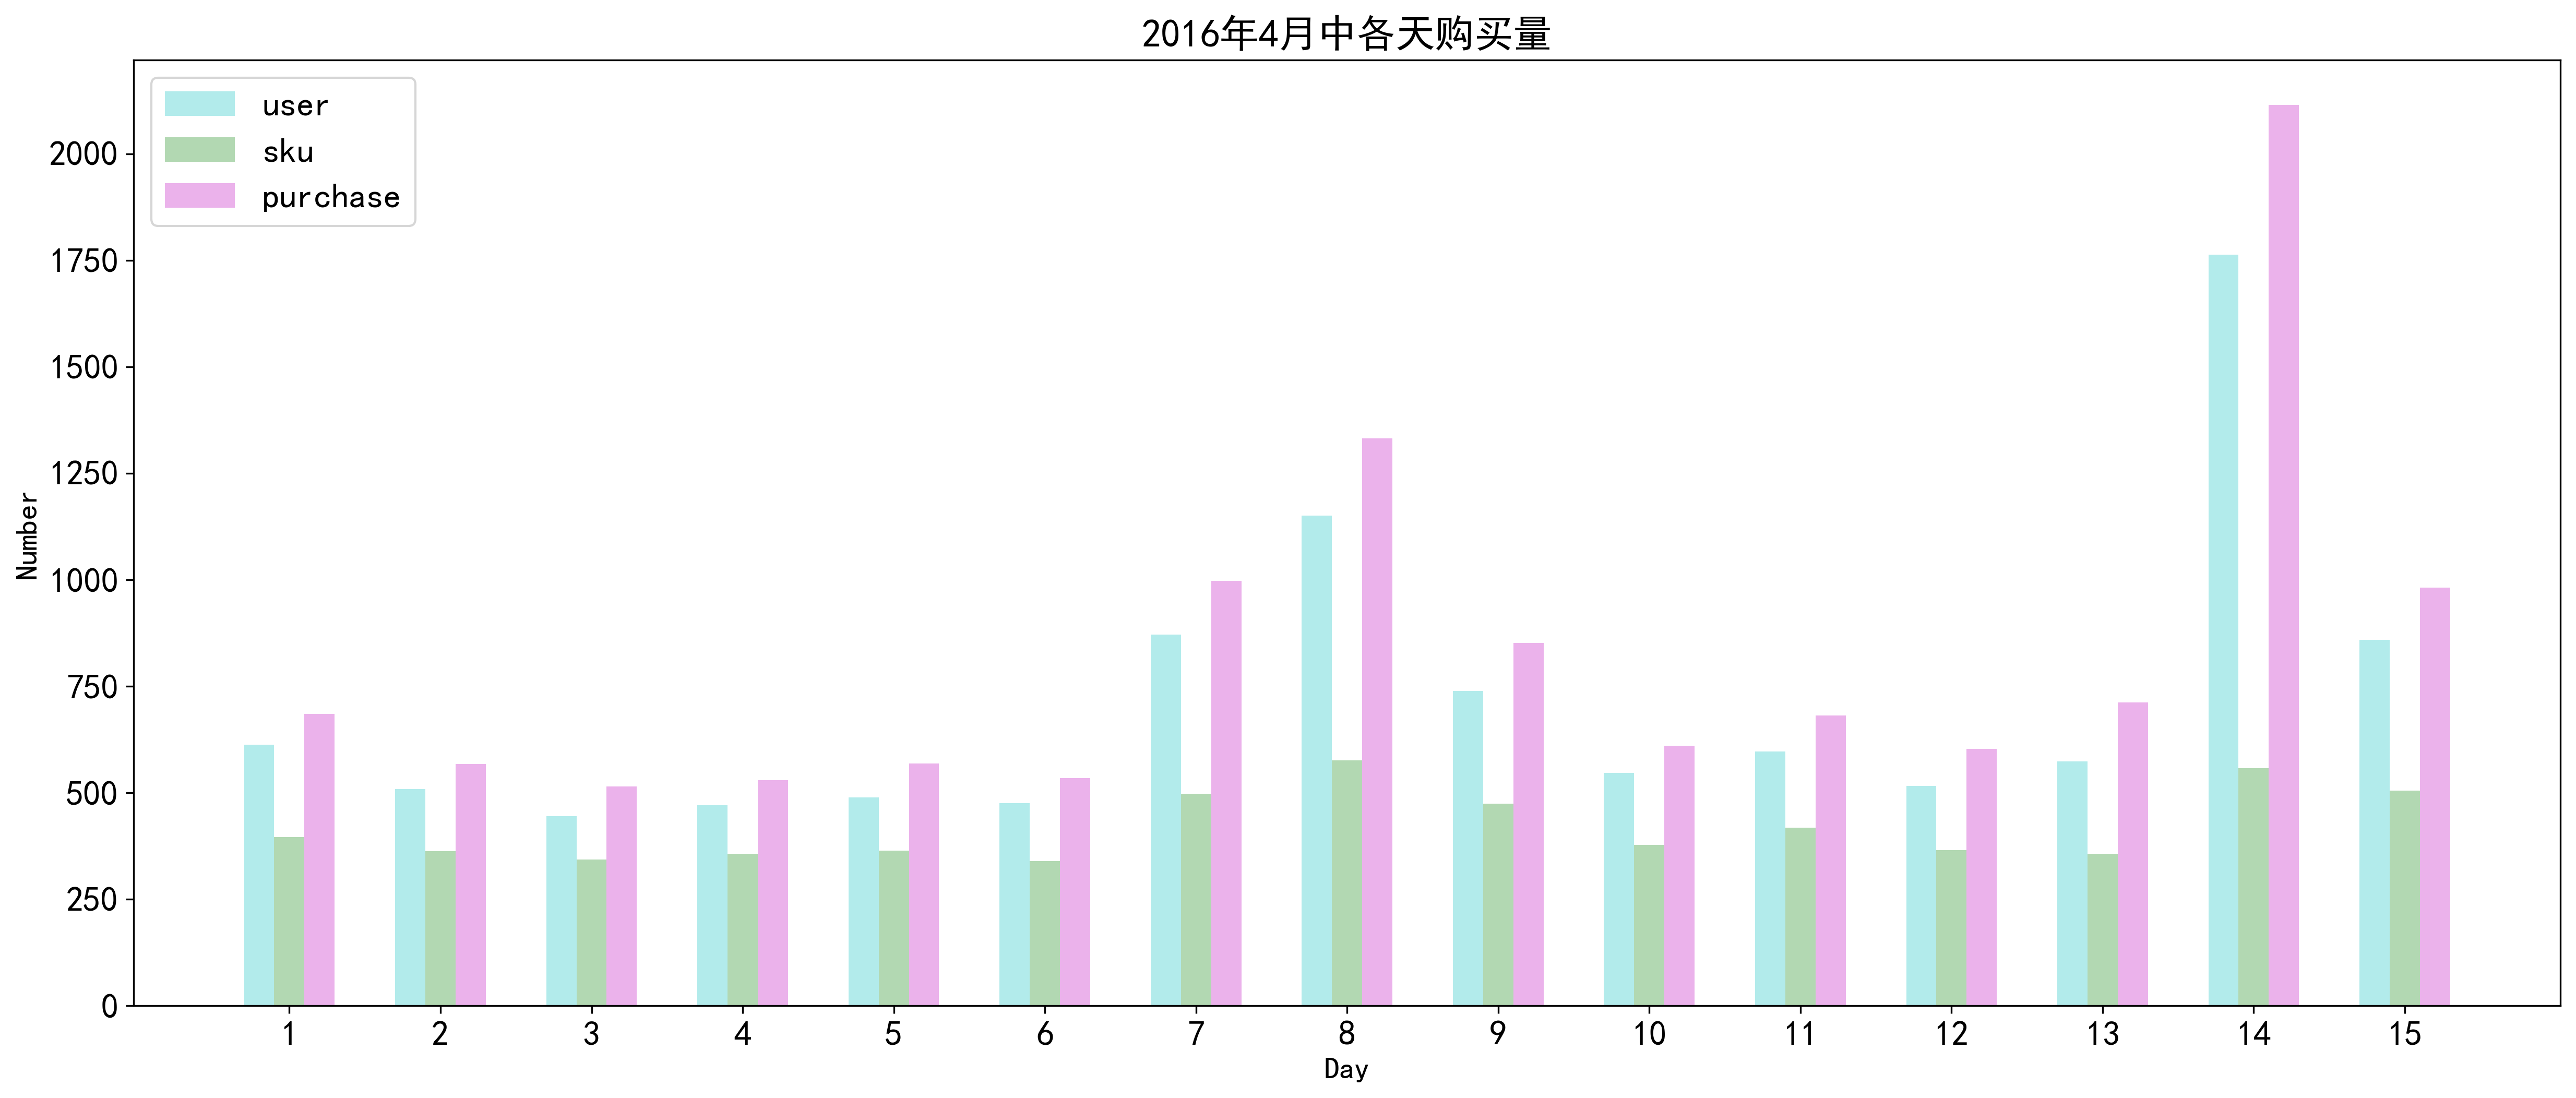

In [53]:
# 准备数据 & 构图

# 获取数据
df_ac04 = get_from_actionData(ACTION_201604_FILE)
df_ac04['day'] = pd.to_datetime(df_ac04.time).apply(lambda x: x.day)
# 购买人数
group_user_04 = df_ac04.groupby('day')['user_id'].nunique()
# 被购买sku数
group_sku_04 = df_ac04.groupby('day')['sku_id'].nunique()
# 购买记录数
group_purchase_04 = df_ac04.groupby('day').size()

# 画图
figure = plt.figure(figsize=(20, 8), dpi=300)
x = group_user_04.index
width = 0.2
opacity = 0.3
rect1 = plt.bar(x-width, group_user_04.values, width, color='c', alpha=opacity, label='user')
rect2 = plt.bar(x, group_sku_04.values, width, color='g', alpha=opacity, label='sku')
rect3 = plt.bar(x+width, group_purchase_04.values, width, color='m', alpha=opacity, label='purchase')
plt.xticks(x, size=16)
plt.xlabel('Day', size=14)
plt.yticks(size=16)
plt.ylabel('Number', size=14)
plt.title("2016年4月中各天购买量", size=18)
plt.legend(fontsize=16)
plt.show()

### 3.2.5 商品类别销售统计

- 周一至周五商品类别的销售量分布

In [64]:
def get_from_actionData(dframe, chunk_size=50000):
    reader = pd.read_csv(dframe, encoding='gbk', iterator=True)
    chunks = []
    flag = True
    while flag:
        try:
            chunk = reader.get_chunk(chunk_size)
            chunks.append(chunk)
        except StopIteration:
            flag = False
            print("Iteration is stopped.")
    df_ac = pd.concat(chunks, ignore_index=True)
    df_ac = df_ac[df_ac['type']==4]
    # type==4 为购买
    return df_ac[["sku_id", "cate", "brand", "time"]]

In [66]:
df_ac = []
df_ac.append(get_from_actionData(ACTION_201602_FILE))
df_ac.append(get_from_actionData(ACTION_201603_FILE))
df_ac.append(get_from_actionData(ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)
df_ac['weekday'] = pd.to_datetime(df_ac['time']).dt.weekday + 1
df_ac.head()

Iteration is stopped.
Iteration is stopped.
Iteration is stopped.


,sku_id,cate,brand,time,weekday
0,166345,9,306,2016/2/1 0:01,1
1,36692,4,174,2016/2/1 0:02,1
2,9112,5,78,2016/2/1 0:03,1
3,102034,5,78,2016/2/1 0:05,1
4,163550,4,306,2016/2/1 0:06,1


In [68]:
df_ac.groupby('cate').count()

,sku_id,brand,time,weekday
cate,,,,
4,7177,7177,7177,7177
5,5921,5921,5921,5921
6,5228,5228,5228,5228
7,4910,4910,4910,4910
8,11416,11416,11416,11416
9,3340,3340,3340,3340
10,144,144,144,144
11,13,13,13,13


cate           4         5       6         7         8       9      10    11
weekday                                                                     
1       1,122.000 1,055.000 895.000   858.000 1,543.000 548.000 29.000 3.000
2       1,136.000 1,063.000 897.000 1,094.000 2,668.000 769.000 26.000   NaN
3       1,000.000   762.000 717.000   654.000 1,343.000 476.000 27.000 3.000
4       1,838.000   990.000 849.000   638.000 1,740.000 455.000 19.000 4.000
5       1,082.000   920.000 856.000   823.000 1,849.000 452.000 16.000   NaN
6         518.000   598.000 540.000   438.000 1,253.000 355.000 14.000   NaN
7         481.000   533.000 474.000   405.000 1,020.000 285.000 13.000 3.000


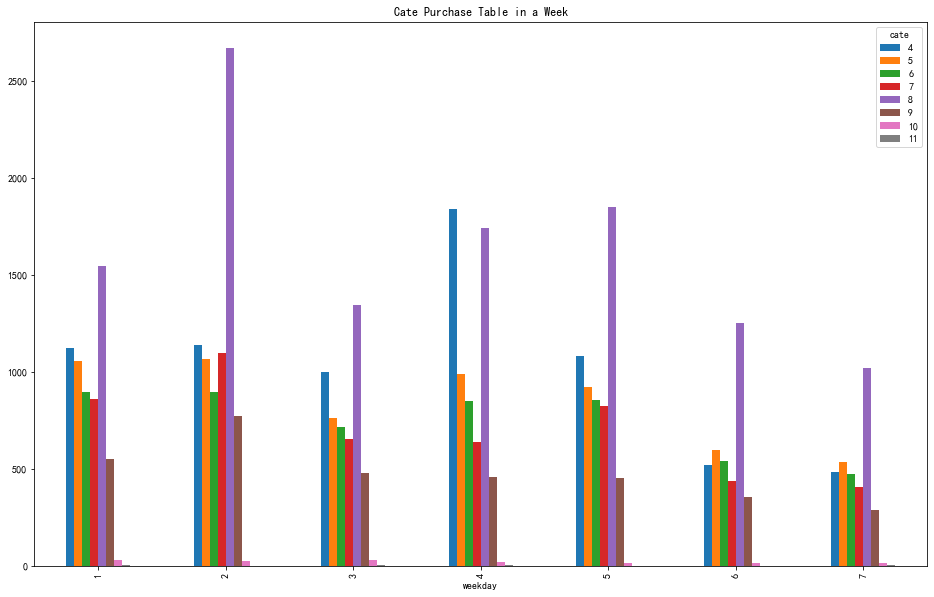

In [81]:
# 周一到周日每天购买不同品类的品牌统计
# group_cate = df_ac.groupby('weekday')['cate'].count()
df_product = df_ac.groupby(['weekday', 'cate'])['brand'].count()
df_product = df_product.unstack()
print(df_product)
df_product.plot(kind='bar', title='Cate Purchase Table in a Week', figsize=(16,10))
plt.show()
"""
cate==8的销量最好，可以深入分析
"""

### 3.2.6 每月各类商品销售情况

In [92]:
df_ac02 = get_from_actionData(ACTION_201602_FILE)
df_ac02['Day'] = pd.to_datetime(df_ac02.time).dt.day

df_ac03 = get_from_actionData(ACTION_201603_FILE)
df_ac03['Day'] = pd.to_datetime(df_ac03.time).dt.day

df_ac04 = get_from_actionData(ACTION_201604_FILE)
df_ac04['Day'] = pd.to_datetime(df_ac04.time).dt.day

Iteration is stopped.
Iteration is stopped.
Iteration is stopped.


In [101]:
df_cate8_02 = df_ac02[df_ac02['cate']==8]
group_cate8_02 = df_cate8_02.groupby('Day')['brand'].count()

df_cate8_03 = df_ac03[df_ac03['cate']==8]
group_cate8_03 = df_cate8_03.groupby('Day')['brand'].count()

df_cate8_04 = df_ac04[df_ac04['cate']==8]
group_cate8_04 = df_cate8_04.groupby('Day')['brand'].count()


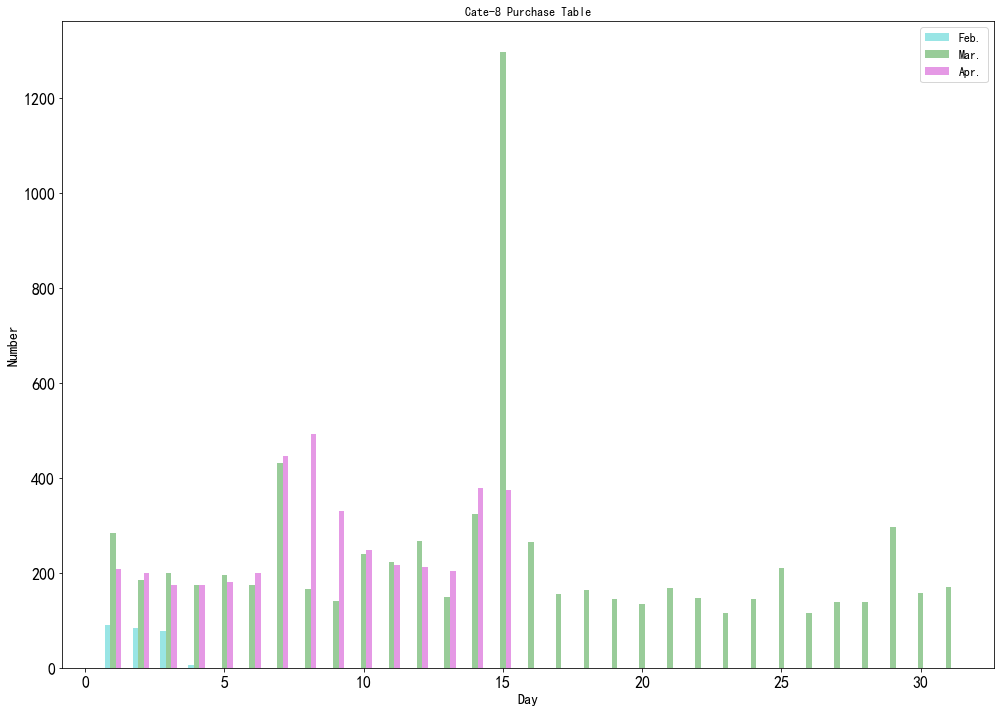

1297

In [122]:
plt.figure(figsize=(14, 10))
width = 0.2
opacity = 0.4
x = range(1, len(df_cate8_03.index)+1, 1)
rect1 = plt.bar(group_cate8_02.index-width, group_cate8_02.values, width, alpha=opacity, color='c', label='Feb.')
rect2 = plt.bar(group_cate8_03.index, group_cate8_03.values, width, alpha=opacity, color='g', label='Mar.')
rect3 = plt.bar(group_cate8_04.index+width, group_cate8_04.values, width, alpha=opacity, color='m', label='Apr.')

plt.xticks(size=16)
plt.xlabel('Day', size=14)
plt.yticks(size=16)
plt.ylabel('Number', size=14)
plt.title("Cate-8 Purchase Table")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

"""
分析，针对品类8：
1. 2月对品类8的购买普遍偏低，3、4月份普遍偏高
2. 3月15的购买量及其多
3. 3,4月份类别8销售记录在前半个月比较相近，除了4月8号，9号和3月15号有较大的差异
"""
brand_total = df_ac.groupby('cate').count()['brand']
cate8_03 = brand_total[8]
cate8_03_15th = group_cate8_03[15]
contribute_15th = cate8_03_15th/cate8_03
contribute_15th